In [1]:
# Here we are importing the libraries that we will need later in our implementations.
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
#Here we are simply importing the Covertype dataset from the UCI Machine Learning Repository
#and turn it into dataframe using pandas read csv so we can preproccess it later
#Note that pandas is the famous library used by Data analysis engineering for data preproccessing.
data_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"
)
raw_data = pd.read_csv(data_url, header=None)
print(f"Dataset shape: {raw_data.shape}") #To review the dimentions ( number of columns and rows)
raw_data.head() #To show the first 5 rows in our data set ( by default 5 but we can show more)

Dataset shape: (581012, 55)


,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [3]:
soil_type_values = [f"soil_type_{idx+1}" for idx in range(40)]
wilderness_area_values = [f"area_type_{idx+1}" for idx in range(4)]

soil_type = raw_data.loc[:, 14:53].apply(
    lambda x: soil_type_values[0::1][x.to_numpy().nonzero()[0][0]], axis=1
)
wilderness_area = raw_data.loc[:, 10:13].apply(
    lambda x: wilderness_area_values[0::1][x.to_numpy().nonzero()[0][0]], axis=1
)

CSV_HEADER = [
    "Elevation",
    "Aspect",
    "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points",
    "Wilderness_Area",
    "Soil_Type",
    "Cover_Type",
]

data = pd.concat(
    [raw_data.loc[:, 0:9], wilderness_area, soil_type, raw_data.loc[:, 54]],
    axis=1,
    ignore_index=True,
)
data.columns = CSV_HEADER

# Convert the target label indices into a range from 0 to 6 (there are 7 labels in total).
data["Cover_Type"] = data["Cover_Type"] - 1

print(f"Dataset shape: {data.shape}")
data.head().T # Visualisation the results

Dataset shape: (581012, 13)


,0,1,2,3,4
Elevation,2596,2590,2804,2785,2595
Aspect,51,56,139,155,45
Slope,3,2,9,18,2
Horizontal_Distance_To_Hydrology,258,212,268,242,153
Vertical_Distance_To_Hydrology,0,-6,65,118,-1
Horizontal_Distance_To_Roadways,510,390,3180,3090,391
Hillshade_9am,221,220,234,238,220
Hillshade_Noon,232,235,238,238,234
Hillshade_3pm,148,151,135,122,150
Horizontal_Distance_To_Fire_Points,6279,6225,6121,6211,6172


In [18]:
train_splits = []
test_splits = []

for _, group_data in data.groupby("Cover_Type"):
    random_selection = np.random.rand(len(group_data.index)) <= 0.85
    train_splits.append(group_data[random_selection])
    test_splits.append(group_data[~random_selection])

train_data = pd.concat(train_splits).sample(frac=1).reset_index(drop=True)
test_data = pd.concat(test_splits).sample(frac=1).reset_index(drop=True)

print(f"Train split size: {len(train_data.index)}")
print(f"Test split size: {len(test_data.index)}")

Train split size: 493961
Test split size: 87051


In [5]:
# Here we will export train set and test set in separates CSV files.
train_data_file = "train_data.csv"
test_data_file = "test_data.csv"

train_data.to_csv(train_data_file, index=False)
test_data.to_csv(test_data_file, index=False)

# Next step we will define metadata of our dataset that will be used in ready and parsing the data into input features.

In [6]:
TARGET_FEATURE_NAME = "Cover_Type"

TARGET_FEATURE_LABELS = ["0", "1", "2", "3", "4", "5", "6"]

NUMERIC_FEATURE_NAMES = [
    "Aspect",
    "Elevation",
    "Hillshade_3pm",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Horizontal_Distance_To_Fire_Points",
    "Horizontal_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Slope",
    "Vertical_Distance_To_Hydrology",
]

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "Soil_Type": list(data["Soil_Type"].unique()),
    "Wilderness_Area": list(data["Wilderness_Area"].unique()),
}

CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())

FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES

COLUMN_DEFAULTS = [
    [0] if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME] else ["NA"]
    for feature_name in CSV_HEADER
]

NUM_CLASSES = len(TARGET_FEATURE_LABELS)

In [7]:
def get_dataset_from_csv(csv_file_path, batch_size, shuffle=False):

    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=True,
        shuffle=shuffle,
    )
    return dataset.cache()

In [8]:
#here we will configre the hyperparametes
#next we will build implementation and training method
learning_rate = 0.001
dropout_rate = 0.1
batch_size = 265
num_epochs = 50

hidden_units = [32, 32]


def run_experiment(model):

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )

    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)

    test_dataset = get_dataset_from_csv(test_data_file, batch_size)

    print("Start training the model...")
    history = model.fit(train_dataset, epochs=num_epochs)
    print("Model training finished")

    _, accuracy = model.evaluate(test_dataset, verbose=0)

    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

In [9]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

In [10]:
from tensorflow.keras.layers import StringLookup


def encode_inputs(inputs, use_embedding=False):
    encoded_features = []
    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            # Create a lookup to convert string values to an integer indices.
            # Since we are not using a mask token nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and  num_oov_indices to 0.
            lookup = StringLookup(
                vocabulary=vocabulary,
                mask_token=None,
                num_oov_indices=0,
                output_mode="int" if use_embedding else "binary",
            )
            if use_embedding:
                # Convert the string input values into integer indices.
                encoded_feature = lookup(inputs[feature_name])
                embedding_dims = int(math.sqrt(len(vocabulary)))
                # Create an embedding layer with the specified dimensions.
                embedding = layers.Embedding(
                    input_dim=len(vocabulary), output_dim=embedding_dims
                )
                # Convert the index values to embedding representations.
                encoded_feature = embedding(encoded_feature)
            else:
                # Convert the string input values into a one hot encoding.
                encoded_feature = lookup(tf.expand_dims(inputs[feature_name], -1))
        else:
            # Use the numerical features as-is.
            encoded_feature = tf.expand_dims(inputs[feature_name], -1)

        encoded_features.append(encoded_feature)

    all_features = layers.concatenate(encoded_features)
    return all_features

# Experiment 1: a baseline model

D:\Programmes\Python\Python310\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


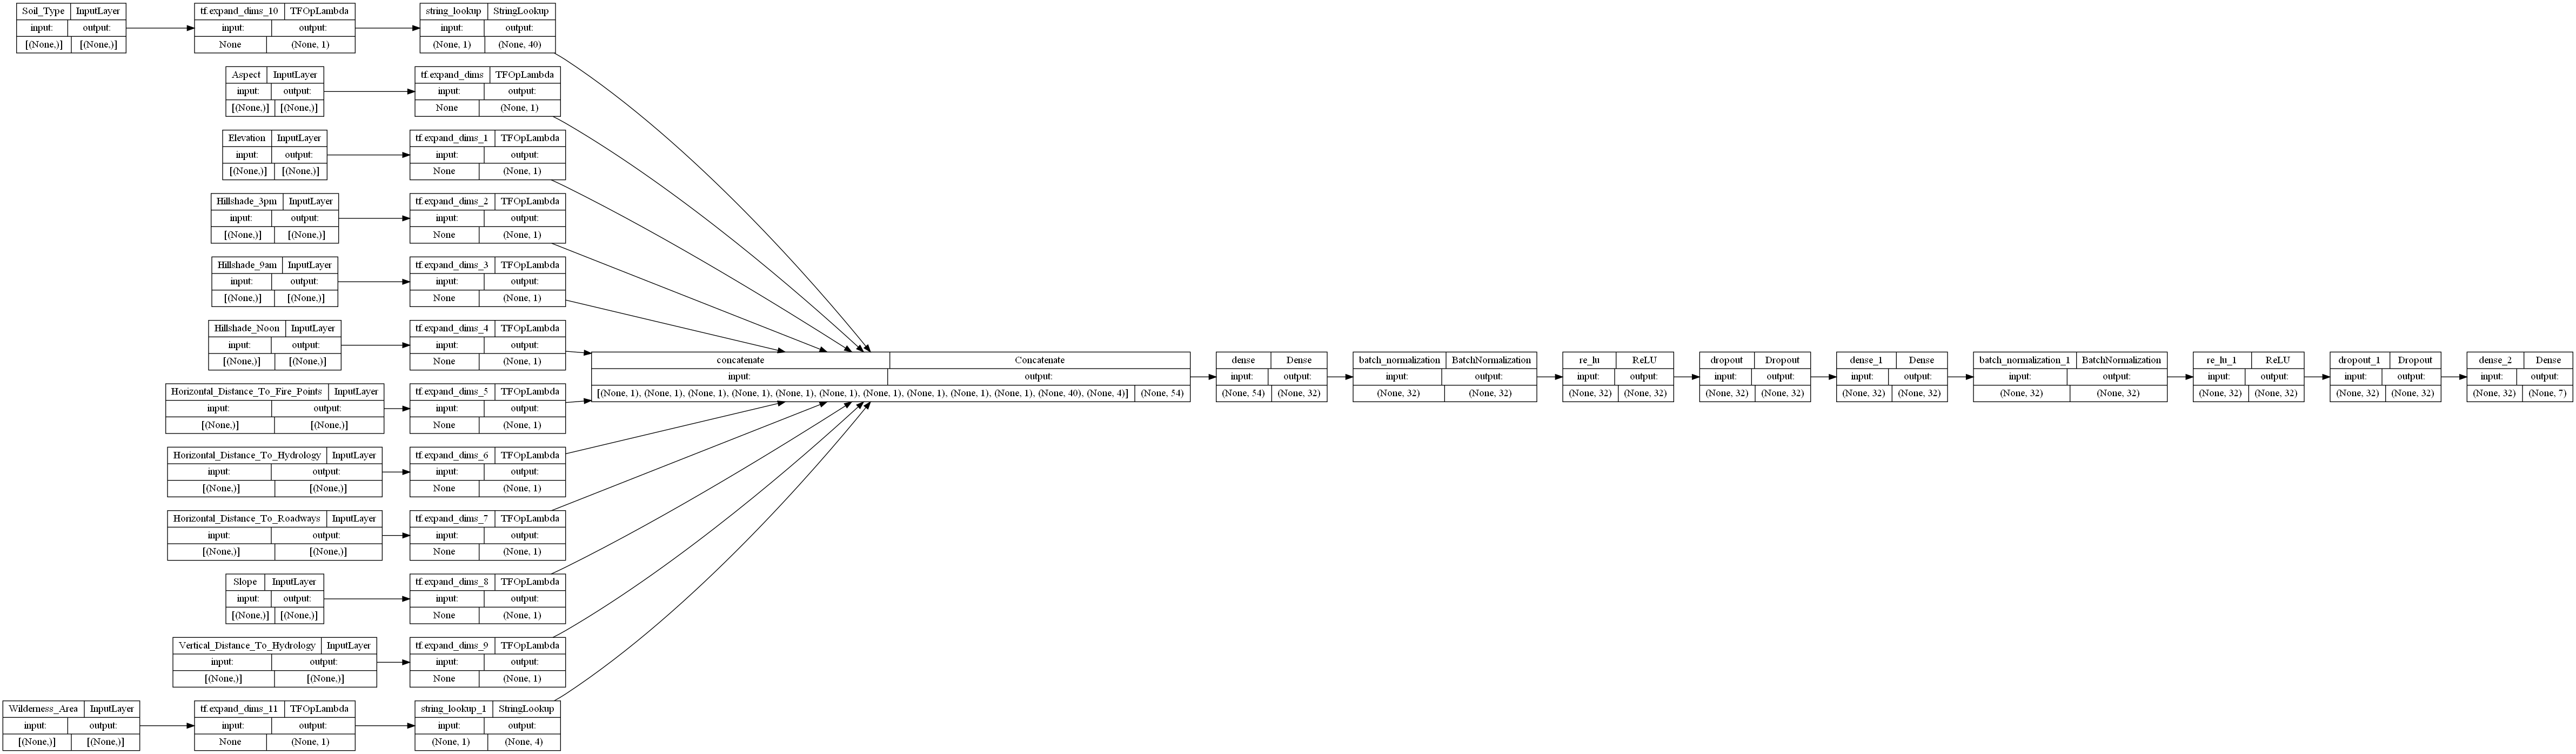

In [11]:
#First we will create a multi-layer feed-forward network, where the categorical features are one-hot encoded.
def create_baseline_model():
    inputs = create_model_inputs()
    features = encode_inputs(inputs)

    for units in hidden_units:
        features = layers.Dense(units)(features)
        features = layers.BatchNormalization()(features)
        features = layers.ReLU()(features)
        features = layers.Dropout(dropout_rate)(features)

    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


baseline_model = create_baseline_model()
keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="LR")

In [12]:
#Here we are training our model
run_experiment(baseline_model)

Start training the model...
Epoch 1/50
1863/1863 [==============================] - 13s 6ms/step - loss: 0.7671 - sparse_categorical_accuracy: 0.6829
Epoch 2/50
1863/1863 [==============================] - 7s 4ms/step - loss: 0.6669 - sparse_categorical_accuracy: 0.7145
Epoch 3/50
1863/1863 [==============================] - 7s 4ms/step - loss: 0.6405 - sparse_categorical_accuracy: 0.7247
Epoch 4/50
1863/1863 [==============================] - 7s 4ms/step - loss: 0.6206 - sparse_categorical_accuracy: 0.7332
Epoch 5/50
1863/1863 [==============================] - 11s 6ms/step - loss: 0.6074 - sparse_categorical_accuracy: 0.7393
Epoch 6/50
1863/1863 [==============================] - 9s 5ms/step - loss: 0.5984 - sparse_categorical_accuracy: 0.7429
Epoch 7/50
1863/1863 [==============================] - 10s 5ms/step - loss: 0.5915 - sparse_categorical_accuracy: 0.7461
Epoch 8/50
1863/1863 [==============================] - 8s 4ms/step - loss: 0.5856 - sparse_categorical_accuracy: 0.7489
E

# Experiment 2: Wide & Deep model

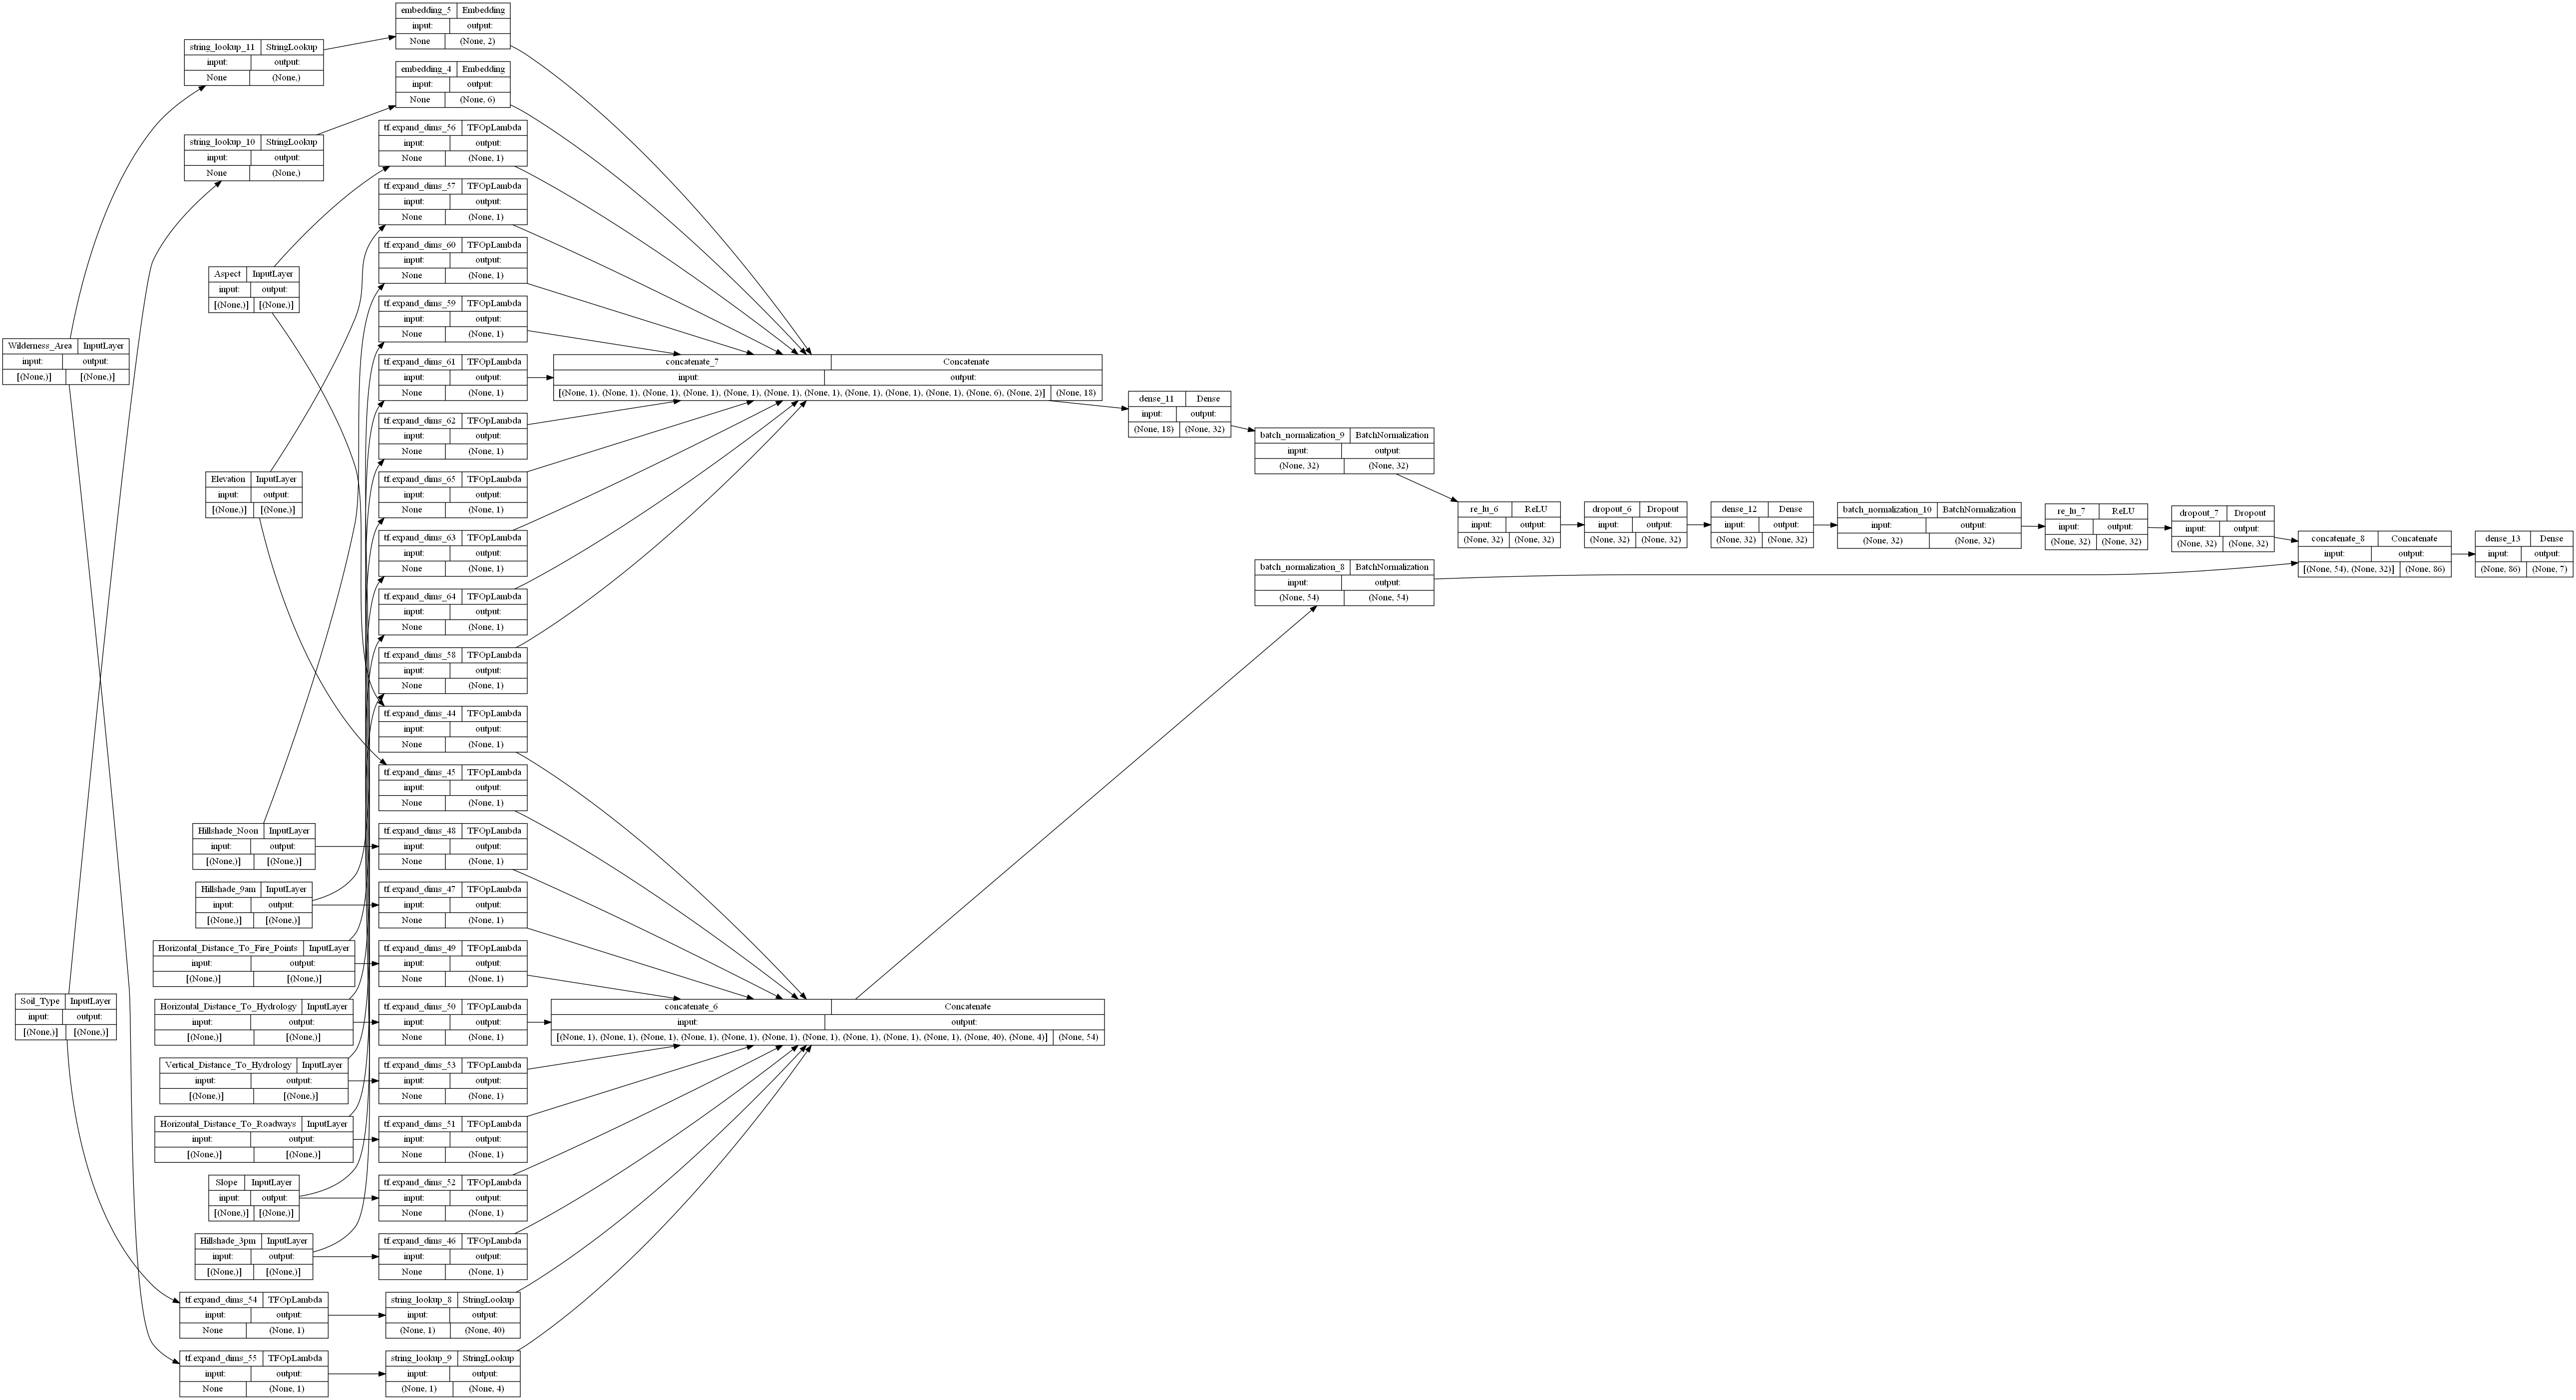

In [19]:
# The model containt two parts , the wide part a linear model, and the deep part is a multi-layer feed-forward network.
def create_wide_and_deep_model():

    inputs = create_model_inputs()
    wide = encode_inputs(inputs)
    wide = layers.BatchNormalization()(wide)

    deep = encode_inputs(inputs, use_embedding=True)
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([wide, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


wide_and_deep_model = create_wide_and_deep_model()
keras.utils.plot_model(wide_and_deep_model, show_shapes=True, rankdir="LR")

In [14]:
#Here we are training our model
run_experiment(wide_and_deep_model)

Start training the model...
Epoch 1/50
1863/1863 [==============================] - 12s 6ms/step - loss: 0.7121 - sparse_categorical_accuracy: 0.7039
Epoch 2/50
1863/1863 [==============================] - 6s 3ms/step - loss: 0.6071 - sparse_categorical_accuracy: 0.7376
Epoch 3/50
1863/1863 [==============================] - 6s 3ms/step - loss: 0.5882 - sparse_categorical_accuracy: 0.7451
Epoch 4/50
1863/1863 [==============================] - 6s 3ms/step - loss: 0.5753 - sparse_categorical_accuracy: 0.7505
Epoch 5/50
1863/1863 [==============================] - 7s 4ms/step - loss: 0.5653 - sparse_categorical_accuracy: 0.7547
Epoch 6/50
1863/1863 [==============================] - 6s 3ms/step - loss: 0.5582 - sparse_categorical_accuracy: 0.7578
Epoch 7/50
1863/1863 [==============================] - 6s 3ms/step - loss: 0.5532 - sparse_categorical_accuracy: 0.7603
Epoch 8/50
1863/1863 [==============================] - 7s 4ms/step - loss: 0.5492 - sparse_categorical_accuracy: 0.7622
Epo

# Experiment 3: Deep & Cross model

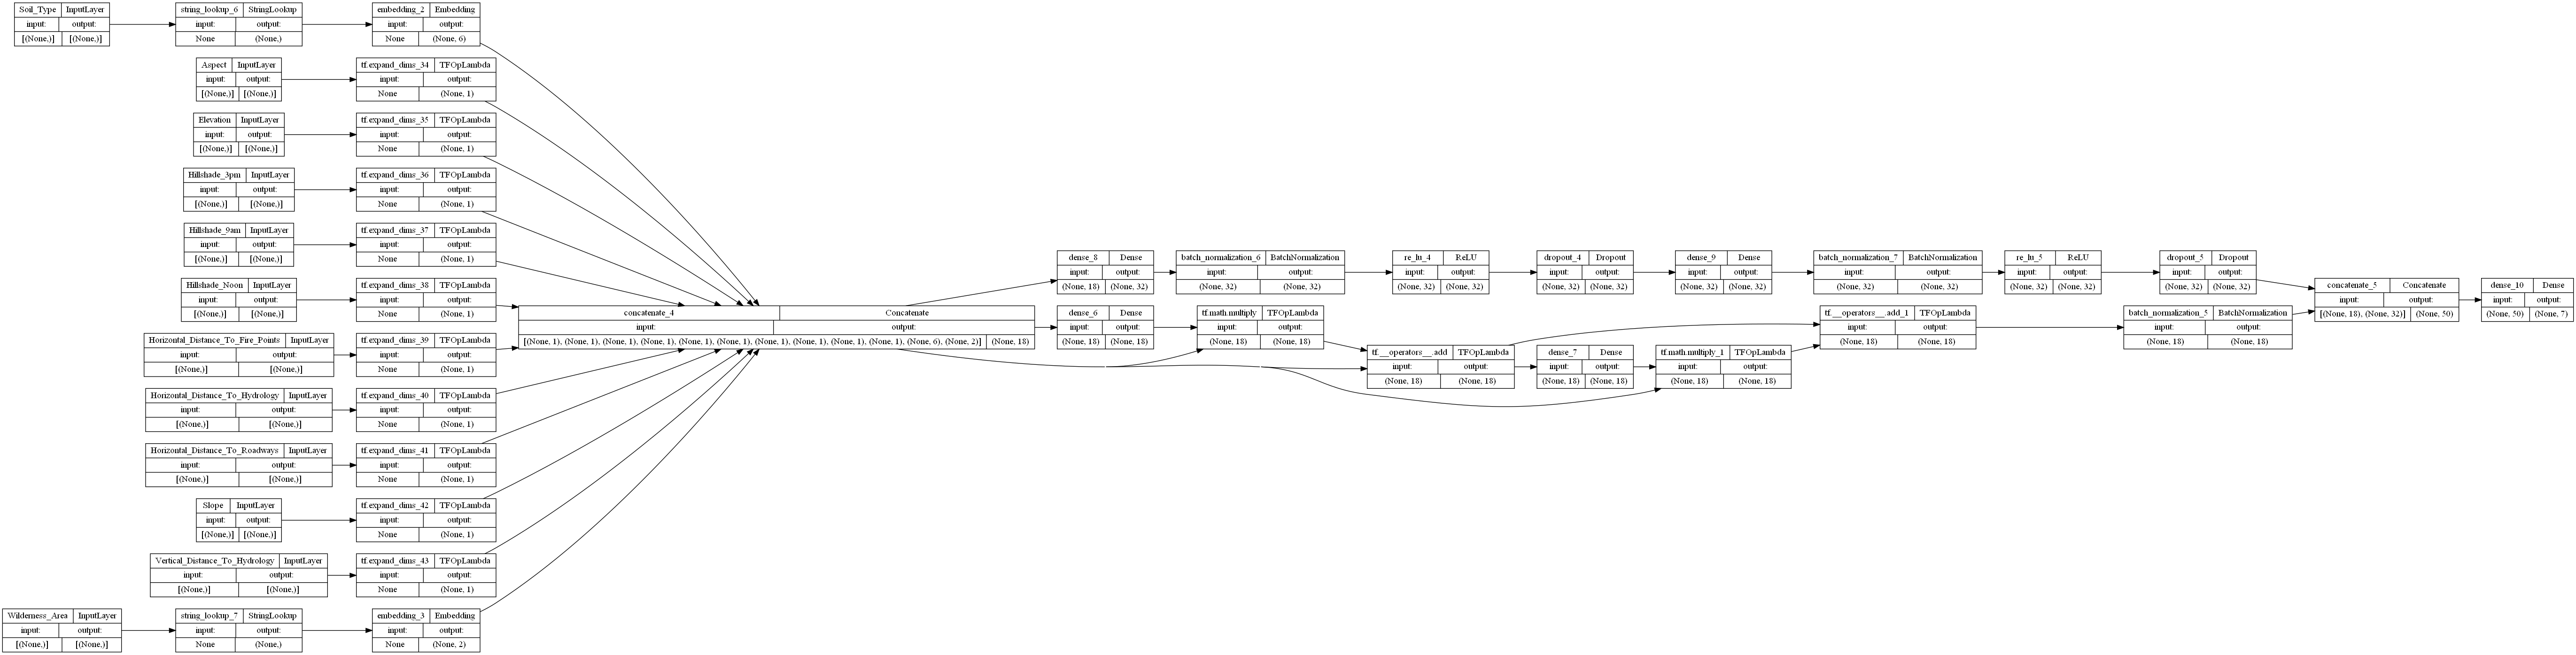

In [15]:
# This model containt also two parts, the wide part is the same as the previous model, the main idea is that 
#the key idea of the cross part is to apply explicit feature crossing in an efficient way.
def create_deep_and_cross_model():

    inputs = create_model_inputs()
    x0 = encode_inputs(inputs, use_embedding=True)

    cross = x0
    for _ in hidden_units:
        units = cross.shape[-1]
        x = layers.Dense(units)(cross)
        cross = x0 * x + cross
    cross = layers.BatchNormalization()(cross)

    deep = x0
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([cross, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


deep_and_cross_model = create_deep_and_cross_model()
keras.utils.plot_model(deep_and_cross_model, show_shapes=True, rankdir="LR")

In [16]:
#Here we are training our model
run_experiment(deep_and_cross_model)

Start training the model...
Epoch 1/50
1863/1863 [==============================] - 10s 5ms/step - loss: 0.6982 - sparse_categorical_accuracy: 0.7096
Epoch 2/50
1863/1863 [==============================] - 6s 3ms/step - loss: 0.5872 - sparse_categorical_accuracy: 0.7473
Epoch 3/50
1863/1863 [==============================] - 6s 3ms/step - loss: 0.5668 - sparse_categorical_accuracy: 0.7569
Epoch 4/50
1863/1863 [==============================] - 5s 3ms/step - loss: 0.5560 - sparse_categorical_accuracy: 0.7615
Epoch 5/50
1863/1863 [==============================] - 5s 3ms/step - loss: 0.5489 - sparse_categorical_accuracy: 0.7641
Epoch 6/50
1863/1863 [==============================] - 6s 3ms/step - loss: 0.5434 - sparse_categorical_accuracy: 0.7666
Epoch 7/50
1863/1863 [==============================] - 6s 3ms/step - loss: 0.5380 - sparse_categorical_accuracy: 0.7688
Epoch 8/50
1863/1863 [==============================] - 6s 3ms/step - loss: 0.5340 - sparse_categorical_accuracy: 0.7700
Epo